In [98]:
sc

In [53]:
import numpy as np
import optimize_camera as optimize
import project_lidar as project
import matplotlib.pyplot as pl
%matplotlib inline

In [7]:
#mymain.py

guess         = np.array([0.38, 0.026, 0.5, 977119, 210445, 145, 0.8e3])
score, params = optimize.run("lwir", num_iter=100, params=guess)
print("score  = {0}\nparams = {1}".format(score,params))

# workers = 30
# path    = "data_npy"
# project.run_project(name="lwir", nworkers=workers, params=params, 
#                     directory=path)

params, score [  3.40365050e-01   1.25726345e-02   5.06092727e-02   9.78103700e+05
   2.10594181e+05   5.85865180e+02   6.52634512e+02] 6672.04393563
params, score [  4.03952970e-01   2.12750239e-02   1.52429812e-16   9.76877469e+05
   2.09795543e+05   2.02589268e+02   8.94793249e+02] 284.504511641
params, score [  4.06482289e-01   3.38655496e-02   1.24549904e-16   9.76859255e+05
   2.09769203e+05   1.06746416e+02   9.02509931e+02] 158.899441262
params, score [  4.06482289e-01   3.38655496e-02   1.24549904e-16   9.76859255e+05
   2.09769203e+05   1.06746416e+02   9.02509931e+02] 158.899441262
params, score [  4.06482289e-01   3.38655496e-02   1.24549904e-16   9.76859255e+05
   2.09769203e+05   1.06746416e+02   9.02509931e+02] 158.899441262
params, score [  4.06482289e-01   3.38655496e-02   1.24549904e-16   9.76859255e+05
   2.09769203e+05   1.06746416e+02   9.02509931e+02] 158.899441262
params, score [  4.06482289e-01   3.38655496e-02   1.24549904e-16   9.76859255e+05
   2.09769203e+05

In [99]:
score  = 1932.73583927

params = [4.48603184e+00, -6.39366995e-02, 1.01077828e-35, 9.88508193e+05,
          2.14483372e+05, 7.97190735e+02, 2.85647278e+03]

In [9]:
t1 = np.load('data_npy/x-1001507.241501_y-219055.073690.npy')

In [10]:
t1.shape

(2566144L, 3L)

In [52]:
def colin(params, xyz_a):

	# Unwrap params
	kappa, phi, omega, xs, ys, zs, f = params

	omega = float(omega)
	phi = float(phi) + 0.5*np.pi
	kappa = float(kappa)
	xs = float(xs)
	ys = float(ys)
	zs = float(zs)
	f = float(f)

	# -- utils
	co = np.cos(omega)
	so = np.sin(omega)
	cp = np.cos(phi)
	sp = np.sin(phi)
	ck = np.cos(kappa)
	sk = np.sin(kappa)

	a1 =  cp*ck+sp*so*sk
	b1 =  cp*sk+sp*so*ck
	c1 =  sp*co
	a2 = -co*sk
	b2 =  co*ck
	c2 =  so
	a3 =  sp*ck+cp*so*sk
	b3 =  sp*sk-cp*so*ck
	c3 =  cp*co

	ynum  = a1*(xyz_a[:,0]-xs)+b1*(xyz_a[:,1]-ys)+c1*(xyz_a[:,2]-zs)
	xnum  = a2*(xyz_a[:,0]-xs)+b2*(xyz_a[:,1]-ys)+c2*(xyz_a[:,2]-zs)
	denom = a3*(xyz_a[:,0]-xs)+b3*(xyz_a[:,1]-ys)+c3*(xyz_a[:,2]-zs)

	xx = -f*xnum/denom
	yy = f*ynum/denom

	return np.vstack([xx,yy]).T

In [111]:
def project(filename, params):
    import colin
    from project_lidar import in_picture
    from project_lidar import distance

    # Finds the desired projection
    
#     if globparams == None:
#         params = return_params(globname)
#     else:
#         params = globparams

    omega, phi, kappa, xs, ys, zs, f = params
    image_dims = [1918, 2560]
    image_dims_reversed = np.array([image_dims[1], \
        image_dims[0]])

    # Rearrange
    print "working on: ", filename
    dat = np.load(filename).copy()

    # Multiply by -1 because it apears as inverse; use orient?
    pixel_xy = 1.0*colin.colin(params, dat) 

    # un-center pixel (x,y)
    x = image_dims[0]/2 - pixel_xy[:,0].astype(int)
    y = image_dims[1]/2 + pixel_xy[:,1].astype(int)

    is_in_picture = in_picture(x,y,image_dims)

    index = np.arange(is_in_picture.size)[is_in_picture>0]

    print "npix = ", index.size

    distgrid = np.ones(image_dims_reversed)*(100000.0)
    xgrid =  -1.*np.ones(image_dims_reversed)
    ygrid = -1.*np.ones(image_dims_reversed)

    if index.size==0:
        print "no points, returning..."
        return [distgrid, xgrid, ygrid]

    n   = distance(xs,ys,zs, dat[index,0],dat[index,1],dat[index,2]) 
    x   = x[index]
    y   = y[index]
    dat = dat[index]

    # Add each point to the arrays, given it is visibile (vis[i] == 1)
    # And it is closer to the camera than the current value stored in 
    # the corresponding pixel of the distance array

    nx = distgrid.shape[1]-1
    ny = distgrid.shape[0]-1

    for ii in range(index.size):
        if n[ii]<distgrid[ny-y[ii],nx-x[ii]] and n[ii]>500:
            distgrid[ny-y[ii],nx-x[ii]] = n[ii]
            xgrid[ny-y[ii],nx-x[ii]] = dat[ii,0]
            ygrid[ny-y[ii],nx-x[ii]] = dat[ii,1]

    print "Done with: ",filename
    return [distgrid, xgrid, ygrid]


In [101]:
lidar_fiducials = np.array([
                            [988224.09, 211951.573,1494.756662], #Empire state building
                            [980598.406, 199043.071,1750.127224], #WTC
                            [987656.616, 211766.233,493.89], # 1250 Broadway
                            [983564.98, 199358.775,591.406796], # Marshall courthouse
                            [987342.468, 212511.054,380.69], #  112 West 34th St
                            [988596.086, 211789.785,255.31], # 347 5th Ave
                            [988287.232, 213228.734,488.716947]])

In [102]:
np.save('bof_fiducials.npy', lidar_fiducials)

In [117]:
# x-978979.241501_y-208815.073690.npy
distgrid, xgrid, ygrid = project('data_npy/x-978979.241501_y-198575.073690.npy', params)

working on:  data_npy/x-978979.241501_y-198575.073690.npy
npix =  3283567
Done with:  data_npy/x-978979.241501_y-198575.073690.npy


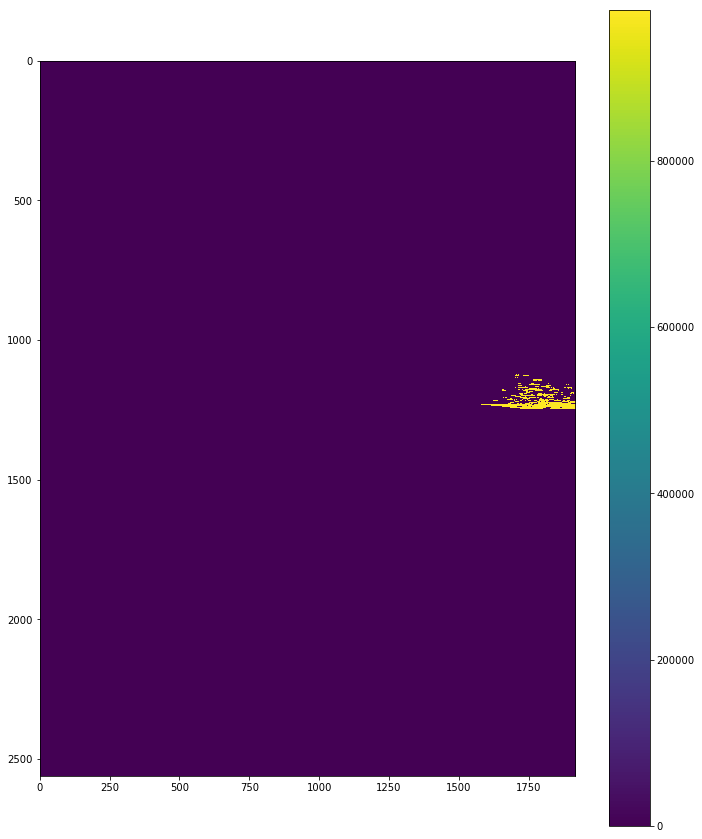

In [118]:
pl.figure(figsize=(12, 15))
pl.imshow(xgrid)

pl.colorbar()

In [116]:
np.where(xgrid!=-1)

(array([ 326,  936, 1134, 1402, 1645, 1695, 1796], dtype=int64),
 array([ 635, 1677, 1215, 1181, 1878,  190,  807], dtype=int64))

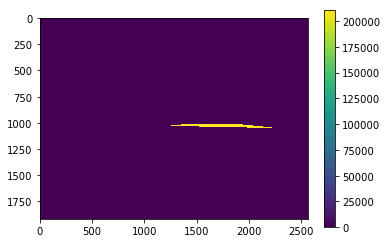

In [96]:
pl.imshow(ygrid)
pl.colorbar()

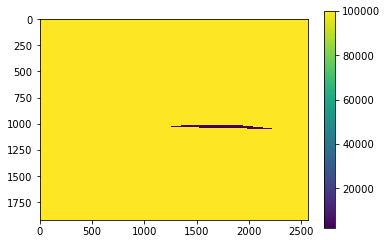

In [97]:
pl.imshow(distgrid)
pl.colorbar()

In [85]:
def merge(final, new):
    
    out = [0, 0, 0]
    replace = np.greater(final[0], new[0])
    out[0] = final[0]*np.logical_not(replace) + new[0]*replace
    out[1] = final[1]*np.logical_not(replace) + new[1]*replace
    out[2] = final[2]*np.logical_not(replace) + new[2]*replace
    return out